# Detecting Trends in Twitter Health News

## Motivation
Twitter has become a major source for data in recent years and it provides great opportunities for data scientists and analysists to develop models to try and solve whatever problem they have in mind since everything is being shared. One of the important areas is health and twitter has a lot of information from news agencies. By considering health tweets, we can get a lot of insights on the health problems the world faced during the time if the collected data, and we can know what problems were popular or not. For our project, our goal is to find a way to detect trends of health issues. More specifically the questions we are trying to answer are: When does flu become an important issue each year (for the years the data was collected), and can we find another major health issue that has recurring patterns and be able to apply the same model to it? This problem is sure to be done before but not in the same way we are presenting it, we are not sure how it is being done but we can assume that there are some tools that have been developed so that medical professionals always are in the know for trends in health issues.

In [53]:
# Create the Spark Context (sc)
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc.setLogLevel("WARN")

In [54]:
# Define a method for reading and processing individual lines of a text file
def preprocessLine(line):
    if (line != ''):
        import re
    
        # Convert characters to upper-case
        text_upper = line.upper()
    
        # Split lines based on "|" separator
        lines = [w for w in text_upper.split('|') if w is not '']
    
        words = []
    
        # Get the date
        date = lines[1].split(' ')[1] + ' '+ lines[1].split(' ')[5]
        words.append(date)
    
        # Clean words from unkwown characters and split into array of words
        clean_words = re.sub(r'[^a-zA-Z]', ' ', lines[2])
        words.append(clean_words.split(' '))

        return words
    else:
        return

# given a tweet, return date and tweet
def makeTweetDate(tweet):
    print(tweet)
    return (tweet[0], tweet[1])

# given a tweet as an array of words return a tuple with date as key and an array of the the words where each element 
# is a tuple of the form (word, 1)
def makeTweetValue(tweet, value=1):
    # List of common words that provide no value and should be remove from dataset
    remove_words = ["HTTP", "YOU", "COM", "THEY", "SHE", "HIM", "HER", "OUR", "FOR", "WHY", "WHAT", 
                    "WHERE", "THE", "AND", "WITH", "YOUR", "WHEN", "BBC","NBCNEWS", "NEW", "CNN", 
                    "ARE", "MORE", "FROM", "MSN", "HOW", "CAN", "WWW", "THIS", "WSJ", "THAT", 
                    "ABOUT", "HAVE", "HAS", "NOT", "CBC", "RSS", "THESE", "BUT"]
    words = []
    for i in range(len(tweet[1])):
        if (tweet[1][i] != '' and len(tweet[1][i]) >= 3 and tweet[1][i] not in remove_words):
            words.append((tweet[1][i], value))
            # (date, [(word, 1), (word, 1) ...])
    return (tweet[0], words)
            
    

# Given a key and value, return a (key, value) pair
def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key
def addValues(val1, val2):    
    return val1 + val2


In [55]:
# Create the RDD containing all the tweets data from all the files
data = sc.textFile('./Health-Tweets/*.txt')

# Creae list of the form: [["MONTH YEAR", ["WORD", "WORD" ...]]]
tweets = data.map(lambda line: preprocessLine(line))


In [56]:
# Map to ("MONTH YEAR", ["WORD", "WORD" ...])]
tweet_date = tweets.map(makeTweetDate)

# Reduce to unique dates
combined = tweet_date.reduceByKey(addValues)

# Make key value pairs of the array
#[("MONTH YEAR", [("WORD", 1), ("WORD", 1), ("WORD", 1) ...])]
word_count_keyValue = combined.map(makeTweetValue)
result = word_count_keyValue.collect()

# Reduce more to count words for each date 
#[("MONTH YEAR", [("WORD", 4), ("WORD", 10), ("WORD", 15) ...])]
words_count = []
for date, words in result:
    words_rdd = sc.parallelize(words)
    count = words_rdd.reduceByKey(addValues).collect()
    words_count.append((date, count))
    


In [57]:
words_count_rdd = sc.parallelize(words_count)

dateDict = dict({
    "JAN": "1",
    "FEB": "2",
    "MAR": "3",
    "APR": "4",
    "MAY": "5",
    "JUN": "6",
    "JUL": "7",
    "AUG": "8",
    "SEP": "9",
    "OCT": "10",
    "NOV": "11",
    "DEC": "12"
})

# This will convert Month names to numbers
def convertMonthToNumbers(month_tweet):
    newDate = ""
    date = month_tweet[0]
    date = month_tweet[0].split(' ')
    newDate = dateDict[date[0]] + ' ' + date[1]
    return (newDate, month_tweet[1])

wc_month_numbers = words_count_rdd.map(convertMonthToNumbers)

# sort dates incrementaly by month and year
time_range = sorted(wc_month_numbers.keys().collect(), key = lambda x: (int(x.split(' ')[1]), int(x.split(' ')[0])))


# Plot Data

In [58]:
from matplotlib import pyplot as plt
import numpy as np

def plotData(keyword, data=wc_month_numbers, t_range=time_range):
    month_year = [date.split(' ') for date in t_range]
    min_month = int(month_year[0][0])
    min_year = int(month_year[0][1])
    max_month = int(month_year[-1][0])
    max_year = int(month_year[-1][1])
    
    
    # group years together
    start = 0
    years = []
    new_year = []
    for i in range(len(month_year)):
        if(int(month_year[i][1]) % min_year == start+1):
            years.append(new_year)
            new_year = []
            start+=1
        
        new_year.append(month_year[i])
    years.append(new_year)
    
        
    # get keyword count
    x = np.array(range(1, 13))
    y = np.zeros(12)
    f, ax = plt.subplots(figsize=(12,9))
    for i in range(len(years)):
        y = np.zeros(12)
        for j in range(len(years[i])):
            
            lookup_key = years[i][j][0] + ' ' + years[i][j][1]
            # find entry in RDD
            month_data = sc.parallelize(wc_month_numbers.lookup(lookup_key)[0])
            if(month_data.lookup(keyword) != []):
                y[j] = month_data.lookup(keyword)[0]
            
        #print(y)
        plt.plot(x,y, label = years[i][j][1], linewidth=5)
    
    plt.legend(fontsize=18)
    plt.xticks(range(1,13), fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Month', fontsize=18)
    plt.ylabel('Frequeney', fontsize=18)
    plt_title = "Trends for: '{}' between {}/{} and {}/{}".format(keyword, min_month, min_year, max_month, max_year)
    plt.title(plt_title, fontsize=24)
    plt.show()
    

# Plot for ("FLU")
- Graph indicates rise of tweets with “flu” at the end of each year and beginning of next year, while flattening in the middle of the year.



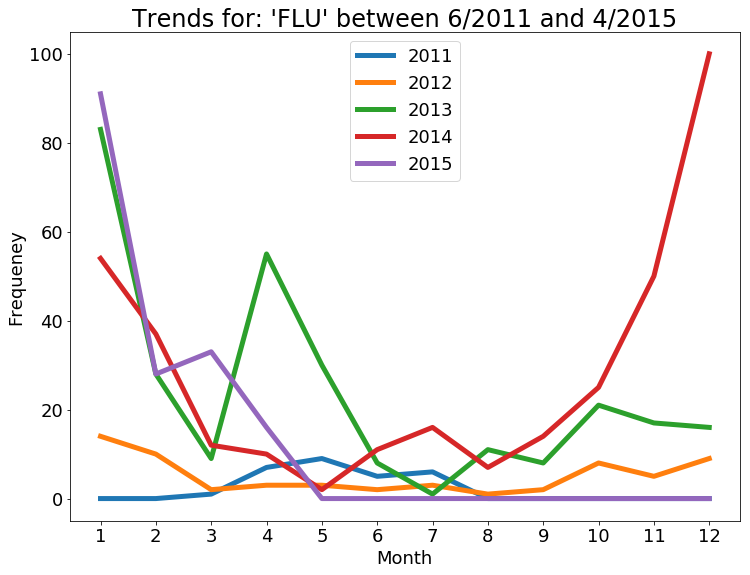

In [59]:
plotData("FLU")

#This will Plot for one year
#plotData("FLU", t_range = ["1 2014", "2 2014", "3 2014", "4 2014", "5 2014", "6 2014", "7 2014", "8 2014", "9 2014", "10 2014", "11 2014", "12 2014"])


# Count Tweets' Words

<Figure size 432x288 with 0 Axes>

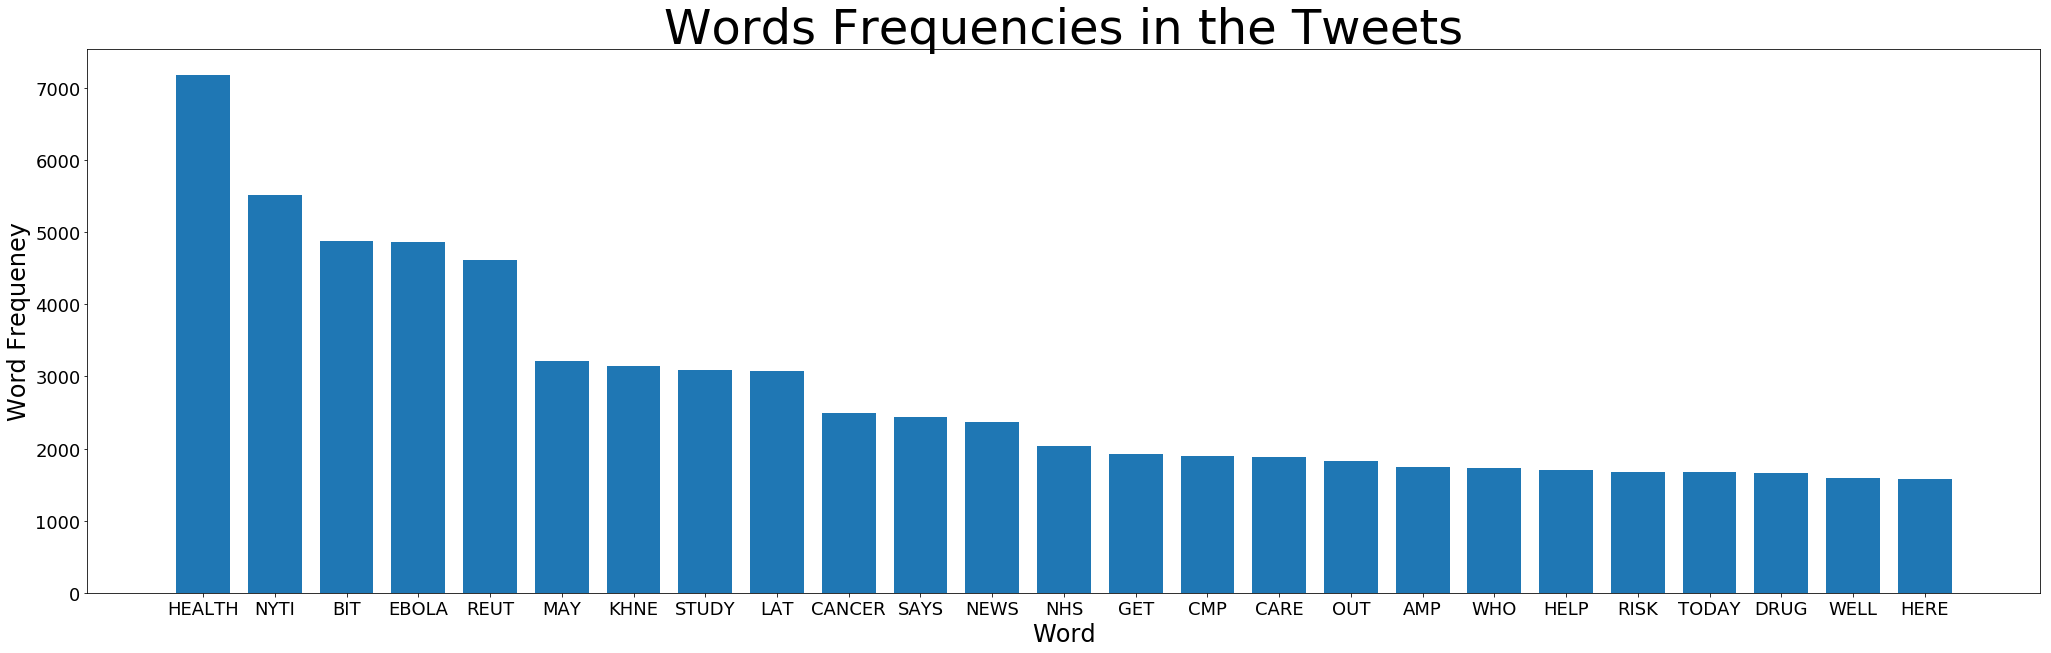

In [60]:
all_words = wc_month_numbers.values().flatMap(lambda x : x)
all_words_count = all_words.reduceByKey(addValues)



# Make sure you clear (i.e., delete) previous figures with this
plt.clf()

# Collect the data from the RDD into a list
results = all_words_count.collect()

# Sort word count list alphabetically
words_freq = sorted(results, key=lambda word: word[1], reverse=True)

# Select first 25 entries
top_entries = words_freq[:25]

# Use the sorted list of tuples contain characters and character counts to get X and Y values
X_vals, Y_vals = zip(*top_entries)

# Plot the histogram
f, ax = plt.subplots(figsize=(35,10))
plt.bar(X_vals, Y_vals, 0.75)
#plt.xlim((.125, len(X_vals)))
plt.xticks(range(0,len(X_vals)), fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Word', fontsize=24)
plt.ylabel('Word Frequeney', fontsize=24)
plt.title('Words Frequencies in the Tweets', fontsize=48)
plt.show()

# Plot for ("EBOLA")
- From the above plot, we find Ebola is the health topic with most tweets
- Graph indicates sharp rise in “Ebola” in tweets mid 2014.
- There was an Ebola epidemic outbreak between 2014-2016 according to CDC.

source:https://www.cdc.gov/vhf/ebola/history/2014-2016-outbreak/index.html


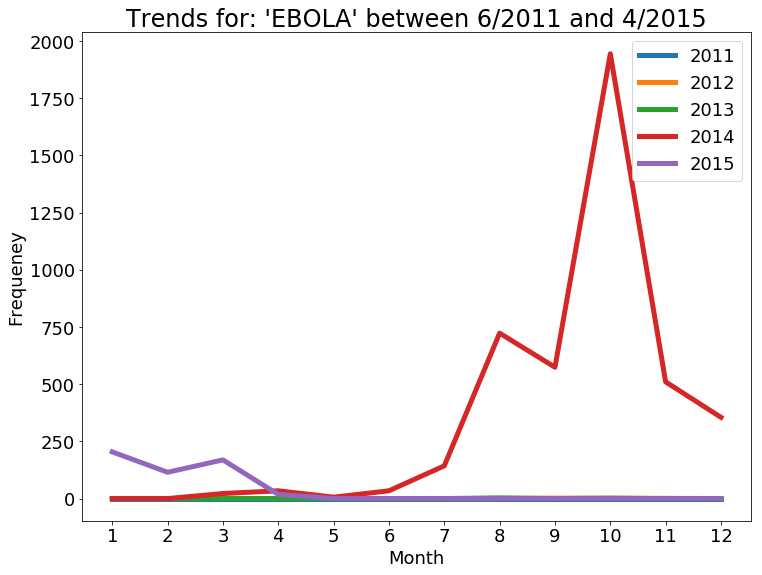

In [61]:
plotData("EBOLA")

# Plot for ("HealthCare")
This plot only verifies that the model works for any keyword

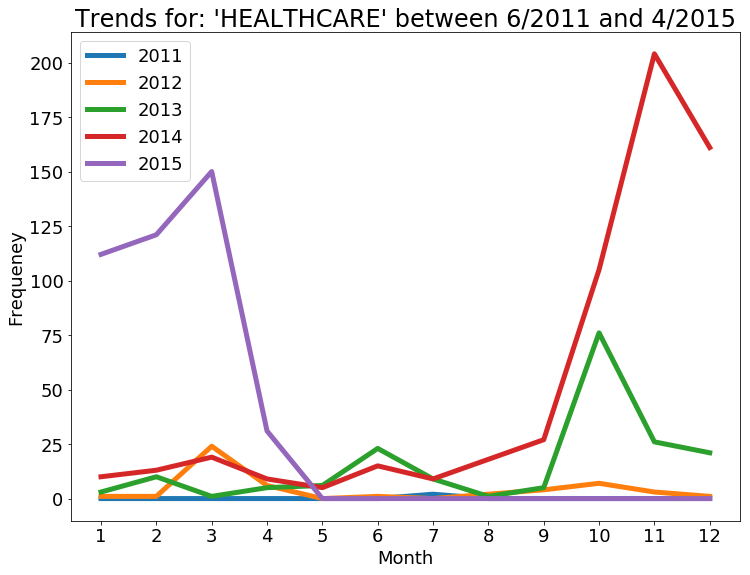

In [62]:
plotData("HEALTHCARE")